Attempting to train a RL algorithm to play the 'Frozen Lake' game from AI gym

In [2]:
import gym
import numpy as np

In [3]:
env = gym.make('FrozenLake-v0')

In [13]:
''' 
Implimenting a Q-Table to play 'Frozen Lake'
'''

# Initialize table with zeros
Q = np.zeros([env.observation_space.n, env.action_space.n])

# Set learning params
lr = .8
gamma = .95
num_episodes = 2000

rList = []

for i in range(num_episodes):
    s = env.reset()
    rAll = 0
    d = False
    
    for j in range(100):
        # Make a move!
        a = np.argmax(Q[s,:] + np.random.randn(1, env.action_space.n) * (1./(i+1)))
        s1, r, d, _ = env.step(a)
        # Use the Bellman Equation to weigh both immediate and long-term predicted rewards
        Q[s,a] = Q[s,a] + lr * (r + gamma * np.max(Q[s1,:]) - Q[s,a])
        rAll += r
        s = s1
        if d == True:
            break
            
    rList.append(rAll)

In [14]:
print ("Score over time: " +  str(sum(rList)/num_episodes))

Score over time: 0.5665


In [15]:
print ("Final Q-Table Values")
print (Q)

Final Q-Table Values
[[3.48244499e-01 4.62576805e-03 4.66075750e-03 4.67050281e-03]
 [5.86762896e-05 1.60397602e-04 8.36104785e-04 1.46235961e-01]
 [1.29278300e-01 2.78783732e-03 9.36136181e-03 3.47597431e-03]
 [9.55195870e-04 1.31857709e-04 2.57229866e-03 8.84350595e-03]
 [5.75639529e-01 2.84987876e-04 3.17721740e-04 1.06970161e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.40764380e-05 9.53097130e-06 1.76481386e-01 1.72123622e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 4.93248553e-03 5.83545363e-03 7.21746422e-01]
 [0.00000000e+00 8.58879609e-01 0.00000000e+00 3.29821501e-03]
 [6.82343728e-01 2.13271563e-04 5.60928792e-04 8.82197411e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 9.37565864e-01 6.48683078e-05]
 [0.00000000e+00 9.91055233e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.

Approaching the same problem, this time with Q-Network Learning, which uses neural networks to provide much greater flexibility and scaling properties than a table.

In [16]:
import random
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
# Ensure everything is in its right place
env = gym.make('FrozenLake-v0')
tf.reset_default_graph()

In [27]:
# Feed-forward part of the network (which is used to choose our actions)
inputs = tf.placeholder(shape=[1,16], dtype=tf.float32)
W = tf.Variable(tf.random_uniform([16, 4], 0, 0.01))
q_out = tf.matmul(inputs, W)
predict = tf.argmax(q_out, 1)

# Calculate loss and update
q_next = tf.placeholder(shape=[1,4], dtype=tf.float32)
loss = tf.reduce_sum(tf.square(q_next - q_out))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
update_model = trainer.minimize(loss)

In [30]:
init = tf.global_variables_initializer()

# Set learning params
gamma = 0.99
error = 0.1
num_episodes = 2000

j_list = []
r_list = []

with tf.Session() as sess:
    
    sess.run(init)
    
    for i in range(num_episodes):
        s = env.reset()
        r_all = 0
        d = False
        
        for j in range(100):
            a, q_all = sess.run([predict, q_out], feed_dict={inputs:np.identity(16)[s:s+1]})
            if np.random.rand(1) < error:
                a[0] = env.action_space.sample()
            s1, r, d, _ = env.step(a[0])
            Q1 = sess.run(q_out, feed_dict={inputs:np.identity(16)[s1:s1+1]})
            maxQ1 = np.max(Q1)
            targetQ = q_all
            targetQ[0, a[0]] = r + gamma * maxQ1
            _, W1 = sess.run([update_model, W], feed_dict={inputs:np.identity(16)[s:s+1], q_next:targetQ})
            r_all += r
            s = s1
            if d == True:
                error = 1./((i/50) + 10)
                break
        j_list.append(j)
        r_list.append(r_all)

print('% successful episodes: ' + str(sum(r_list) / num_episodes) + '%')        

% successful episodes: 0.425%


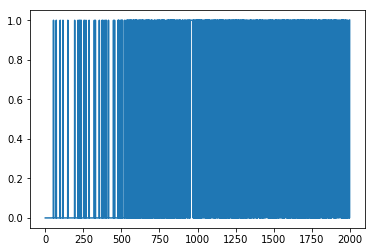

In [31]:
plt.plot(r_list)

We see that we begin to reach the goal just about every time after 500 episodes.

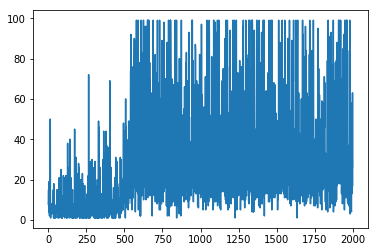

In [32]:
plt.plot(j_list)